### Imports

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import warnings
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user
import datetime
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from tensorflow import keras
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

In [3]:
import datetime
from sklearn.model_selection import StratifiedKFold, KFold
import math

In [4]:
from sklearn.decomposition import PCA

In [5]:

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

### Read Data

In [6]:
df_y_train_c = pd.read_csv(os.path.abspath("../input")+'/y_train.csv')

In [7]:
df_x_train = pd.read_csv(os.path.abspath("../input")+'/X_train.csv', encoding='cp949')
df_x_test = pd.read_csv(os.path.abspath("../input")+'/X_test.csv', encoding='cp949')
df_y_train = pd.read_csv(os.path.abspath("../input")+'/y_train.csv').age
IDtrain = pd.DataFrame({'custid': df_x_train.custid.unique()})
IDtest = pd.DataFrame({'custid': df_x_test.custid.unique()})

## log 데이터 전처리

In [8]:
tr = pd.concat([df_x_train, df_x_test])
tr['real_amt']= tr.tot_amt / tr.inst_mon
tr['dist_rate'] = (tr['dis_amt']/tr['tot_amt'])*100

In [9]:
id_data = pd.DataFrame({'custid': tr.custid.unique()})

In [10]:
tr['sales_hour'] = tr['sales_time']//100
tr['sales_min'] = tr['sales_time']%100

In [11]:
tr["sales_date"] = np.where(tr["sales_month"] >9 , 
                            (tr["sales_month"].astype(str)),("0"+tr["sales_month"].astype(str)))


In [12]:
tr["sales_date"] = np.where(tr["sales_day"]>9,(tr["sales_date"]+tr["sales_day"].astype(str)),
                            (tr["sales_date"]+"0"+tr["sales_day"].astype(str))
                            )

In [13]:
tr["sales_month"] = np.where(tr["sales_month"]>12 , tr["sales_month"]-12, tr["sales_month"])

In [14]:
tr["time"] = pd.to_datetime(tr.sales_time, format = "%H%M")

In [15]:
tr["refund"] = np.where(tr["net_amt"]<0,1,0)

In [16]:
tr['sales_month_ver1'] = tr['sales_month']
tr['sales_month'] = tr['sales_month'].apply(lambda x : x-12 if x > 12 else x )
tr['sales_hour'] = tr['sales_time'].apply(lambda x : x//100 )
tr['sales_sec'] = tr['sales_time'].apply(lambda x : x%100 )
tr['total_sec'] = tr['sales_time'].apply(lambda x : x//100*60 + x%100 )
tr['환불여부'] = tr['tot_amt'].apply(lambda x : 1 if x < 0 else 0 )
tr['refund'] = tr['tot_amt'].apply(lambda x : abs(x) if x < 0 else 0 )
tr['tot_amt'] = tr['tot_amt'] .apply(lambda x : 0 if x < 0 else x )
tr['real_amt'] = ( tr['tot_amt'] / tr['inst_mon'] ).apply(lambda x : math.trunc(x)) 
tr['sales_date'] =tr['sales_month_ver1'].astype(str).apply(lambda x : "0"+x if len(x) == 1  else x ) +tr['sales_day'].astype(str).apply(lambda x : "0"+x if len(x) == 1 else  x )
tr['sales_date'] = tr['sales_date'].astype(int)

In [17]:
df = pd.merge(tr, df_y_train_c, on = 'custid')
tr['age_group'] = df['age'].apply(lambda x : 'twenty' if (x>=20) & (x<30)
                                     else 'thirty' if (x>=30) & (x<40)
                                     else 'forty' if (x>=40) & (x<50)
                                     else 'fifty' if (x>=50) & (x<60)
                                     else 'sixty')

In [18]:
twenty_prefer_brd = tr[tr['age_group'] == 'twenty'].brd_nm.value_counts().index[1:].to_list()
thirty_prefer_brd = tr[tr['age_group'] == 'thirty'].brd_nm.value_counts().index[1:].to_list()
forty_prefer_brd = tr[tr['age_group'] == 'forty'].brd_nm.value_counts().index[1:].to_list()
fifty_prefer_brd = tr[tr['age_group'] == 'fifty'].brd_nm.value_counts().index[1:].to_list()
sixty_prefer_brd = tr[tr['age_group'] == 'sixty'].brd_nm.value_counts().index[1:].to_list()

def prefer_brd(x, list):
    for i in range(len(list)):
        if(x == list[i]):
            return len(list)-i

tr['20_weight'] = tr['brd_nm'].apply(lambda x: prefer_brd(x, twenty_prefer_brd)).fillna(0)
tr['30_weight'] = tr['brd_nm'].apply(lambda x: prefer_brd(x, thirty_prefer_brd)).fillna(0)
tr['40_weight'] = tr['brd_nm'].apply(lambda x: prefer_brd(x, forty_prefer_brd)).fillna(0)
tr['50_weight'] = tr['brd_nm'].apply(lambda x: prefer_brd(x, fifty_prefer_brd)).fillna(0)
tr['60_weight'] = tr['brd_nm'].apply(lambda x: prefer_brd(x, sixty_prefer_brd)).fillna(0)

In [19]:
tr["age_weight_sum"] = tr['20_weight']+tr['30_weight']+tr['40_weight']+tr['50_weight']+tr['60_weight']

In [20]:
tr["sales_season"] = tr['sales_month'].apply(lambda x : 'SPRING' if (x>=3) and (x<=5)
                                                  else 'SUMMER' if (x>=6) and (x<=8)
                                                  else 'FALL' if (x>=9) and (x<=11)
                                                  else 'WINTER')

In [21]:
tr['tot_amt>=0'] = tr['tot_amt'].apply(lambda x : x if x>=0 else 0)
tr['dis_amt>=0'] = tr['dis_amt'].apply(lambda x : x if x>=0 else 0)
tr['net_amt>=0'] = tr['net_amt'].apply(lambda x : x if x>=0 else 0)

# features 생성

In [22]:
features = []

In [23]:
#환불 여부
t = tr.groupby("custid")["refund"].agg([("refund_count","sum")]).reset_index()
t["refund_bool"] = np.where(t["refund_count"]>0,1,0)
features.append(t)

In [24]:
def refund_check(x):
    if x<0:
        return x
    else:
        return 0

- 환불 총액, 평균 , 최대

In [25]:
copy_df = tr.copy()
copy_df["tot_amt_refund"] = copy_df.net_amt.apply(refund_check)
t = copy_df.groupby("custid")["tot_amt_refund"].agg([("amt_refund","sum"),
                                                    ("amt_refund_mean","mean"),
                                                    ("amt_refund_max","min")]).reset_index()
features.append(t)

- 최애브랜드 사용수

In [26]:
def g(x):
    y = x.value_counts()
    y = y.iloc[0]
    return y

f = tr.groupby('custid')['brd_nm'].agg([('love_brd_count', g)]).reset_index()
f = f.fillna(0)
features.append(f)

- 연령대별 브랜드 선호도에 따른 가중치 비율

In [27]:
f = tr.groupby('custid')['20_weight', '30_weight', '40_weight', '50_weight', '60_weight', 'age_weight_sum'].sum()

f['20_weight_ratio'] = f['20_weight'] / f['age_weight_sum']
f['30_weight_ratio'] = f['30_weight'] / f['age_weight_sum']
f['40_weight_ratio'] = f['40_weight'] / f['age_weight_sum']
f['50_weight_ratio'] = f['50_weight'] / f['age_weight_sum']
f['60_weight_ratio'] = f['60_weight'] / f['age_weight_sum']

f = f.fillna(0)
features.append(f)

- 시간대별 방문횟수

In [28]:
t = pd.pivot_table(tr, index='custid', columns='sales_hour', values='tot_amt', 
                   aggfunc=np.size).fillna(0).astype(int).reset_index()
features.append(t)

- 시간대별 구매금액

In [29]:
t = pd.pivot_table(tr, index='custid', columns='sales_hour', values='tot_amt', 
                   aggfunc="sum").fillna(0).astype(int).reset_index().drop([0,1,8,9],axis = 1)
features.append(t)

- 날짜별 방문횟수

In [30]:
t = pd.pivot_table(tr, index='custid', columns='sales_day', values='tot_amt', 
                   aggfunc=np.size).fillna(0).astype(int).reset_index()

In [31]:
f = id_data.copy()
f["month_start"] = 0
f["month_mid"] = 0
f["month_end"] = 0 
for i in [x for x in range(1,11)]:
    f["month_start"] += t[i]
    f["month_mid"] += t[i+10]
    f["month_end"] += t[i+20]
f["month_end"] += t[31]
features.append(f)

- 날짜별 구매금액

In [32]:
t = pd.pivot_table(tr, index='custid', columns='sales_day', values='tot_amt', 
                   aggfunc="sum").fillna(0).astype(int).reset_index()

In [33]:
f = id_data.copy()
f["month_start"] = 0
f["month_mid"] = 0
f["month_end"] = 0 
for i in [x for x in range(1,11)]:
    f["month_start"] += t[i]
    f["month_mid"] += t[i+10]
    f["month_end"] += t[i+20]
f["month_end"] += t[31]
features.append(f)

- 월간별 날짜횟수

In [34]:
t = pd.pivot_table(tr, index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc=np.size).fillna(0).astype(int).reset_index()
features.append(t)

- 월간 구매금액

In [35]:
t = pd.pivot_table(tr, index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc="sum").fillna(0).astype(int).reset_index()
features.append(t)

In [36]:
#쇼핑시간
time_sum = tr.groupby(['sales_date','custid'])['time'].agg([('time', ['min','max'])]).reset_index()
time_sum['shopping_time'] = (time_sum['time']['max'] - time_sum['time']['min']).dt.total_seconds()
time_sum.drop(['sales_date','time'], axis=1, inplace=True,level=0)
time_sum = time_sum.groupby(['custid'])['shopping_time'].agg([('shopping_time_mean','mean')]).reset_index()
features.append(time_sum)

In [37]:
#평균할인율
f = tr.groupby('custid')['dist_rate'].agg([('dis_rate', 'mean')]).reset_index()
features.append(f)

In [38]:
#평균시간
f = tr.groupby(['custid'])['sales_time'].agg([('sales_time', 'mean')]).reset_index()
features.append(f)

In [39]:
#남성파트
df = tr.groupby(['custid','part_nm'])['tot_amt'].agg([('tot_amt_part', 'sum')]).reset_index()
df['part_nm'] = np.where(df.part_nm.str.contains('남성'), '남성', '비남성')
df = df.pivot_table(values='tot_amt_part', index=df.custid, columns='part_nm', aggfunc='first',fill_value=0).reset_index()
df['남성part'] = (df['남성'] / (df['남성'] + df['비남성'])) * 100
df = df.fillna(0)
features.append(df)

In [40]:
#화장품구매비율
df = tr.groupby(['custid','corner_nm'])['tot_amt'].agg([('tot_amt_corner', 'sum')]).reset_index()
df['corner_nm'] = np.where(df.corner_nm.str.contains('화장품'), '화장품', '비화장품')
df = df.pivot_table(values='tot_amt_corner', index=df.custid, columns='corner_nm', aggfunc='first',fill_value=0).reset_index()
df['화장품비율'] = (df['화장품'] / (df['화장품'] + df['비화장품'])) * 100
df = df.fillna(0)
features.append(df)

In [41]:
#할부대비평균실구매
f = tr.groupby('custid')['real_amt'].agg([('real_amt', 'mean')]).reset_index()
features.append(f)

In [42]:
#평균구매상품종류
df =tr.groupby(['custid','goodcd'])['tot_amt'].agg([('good_count', 'count')]).reset_index()
f = df.groupby(['custid'])['good_count'].agg([('good_count_mean', 'mean')]).reset_index()
features.append(f)

In [43]:
#지역
df = tr.groupby(['custid','str_nm'])['tot_amt'].agg([('tot_amt_str', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_str', index=df.custid, columns='str_nm', aggfunc='first',fill_value=0).reset_index()
features.append(df)

In [44]:
#팀별
df = tr.groupby(['custid','team_nm'])['tot_amt'].agg([('tot_amt_team', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_team', index=df.custid, columns='team_nm', aggfunc='first',fill_value=0).reset_index()
features.append(df)

In [45]:
#총구매수입상품
df = tr.groupby(['custid'])['import_flg'].agg([('import_flg_sum', 'sum')]).reset_index()
features.append(df)

In [46]:
#파트
df = tr.groupby(['custid','part_nm'])['tot_amt'].agg([('tot_amt_part', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_part', index=df.custid, columns='part_nm', aggfunc='first',fill_value=0).reset_index()
features.append(df)

In [47]:
#코너
df = tr.groupby(['custid','corner_nm'])['tot_amt'].agg([('tot_amt_corner', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_corner', index=df.custid, columns='corner_nm', aggfunc='first',fill_value=0).reset_index()
features.append(df)

In [48]:
#pc
df = tr.groupby(['custid','pc_nm'])['tot_amt'].agg([('tot_amt_pc', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_pc', index=df.custid, columns='pc_nm', aggfunc='first',fill_value=0).reset_index()
features.append(df)

In [49]:
#총구매액
f = tr.groupby('custid')['tot_amt'].agg([('총구매액', 'sum')]).reset_index()
features.append(f)

In [50]:
#구매건수
f = tr.groupby('custid')['tot_amt'].agg([('구매건수', 'size')]).reset_index()
features.append(f)

In [51]:
#평균구매가격

f = tr.groupby('custid')['tot_amt'].agg([('평균구매가격', "mean")]).reset_index()
features.append(f)

In [52]:
#평균할부개월수
f = tr.groupby('custid')['inst_mon'].agg([('평균할부개월수', 'mean')]).reset_index()
f.iloc[:,1] = f.iloc[:,1].apply(round, args=(1,))
features.append(f)

In [53]:
#구매상품다양성
n = tr.corner_nm.nunique()
f = tr.groupby('custid')['brd_nm'].agg([('구매상품다양성', lambda x: len(x.unique()) / n)]).reset_index()
features.append(f)

In [54]:
#수입상품_구매비율
x = tr[tr['import_flg'] == 1].groupby('custid').size() / tr.groupby('custid').size()
f = x.reset_index().rename(columns={0: '수입상품_구매비율'}).fillna(0)
f.iloc[:,1] = (f.iloc[:,1]*100).apply(round, args=(1,))
features.append(f)

In [55]:
#일평균구매액
test2 = tr.groupby(['sales_date','custid'])['tot_amt'].agg([('day_amt', 'sum')]).reset_index()
test2 = test2.groupby(['custid'])['day_amt'].agg([('일평균구매액', 'mean')]).reset_index()
features.append(test2)

In [56]:
#내점일수 

f = tr.groupby(by = 'custid')['sales_time'].agg([('내점일수','nunique')]).reset_index()
features.append(f)

In [57]:
#일평균구매건
df = tr.groupby(['sales_date','custid'])['custid'].agg([('day_visit', 'count')]).reset_index()
f = df.groupby(['custid'])['day_visit'].agg([('일평균구매건', 'mean')]).reset_index()
features.append(f)

In [58]:
#아동상품 구매건수
f = tr[tr.tot_amt > 0].groupby('custid')['part_nm'].agg([('baby_sales', lambda x: list(x).count('아동')+list(x).count('케주얼,구두,아동')+list(x).count('아동문화')+list(x).count('아동,스포츠'))]).reset_index()
#features.append(f)

In [59]:
#상위 브랜드 40개의 구매빈도
top_brd = tr["brd_nm"].value_counts()[:40].index
df = tr.groupby(['custid','brd_nm'])["custid"].agg([('brd_count', 'count')]).reset_index()
df =df.pivot_table(values='brd_count', index=df.custid, columns="brd_nm", aggfunc='count',fill_value=0).reset_index()
df = pd.concat([df["custid"] ,df[top_brd]],axis= 1)
features.append(df)

In [60]:
#상위 브랜드 40개의 구매금액
df = tr.groupby(['custid','brd_nm'])["tot_amt"].agg([('tot_amt_brd', 'sum')]).reset_index()
df =df.pivot_table(values='tot_amt_brd', index=df.custid, columns="brd_nm", aggfunc='sum',fill_value=0).reset_index()
df = pd.concat([df["custid"] ,df[top_brd]],axis= 1)
features.append(df)

In [61]:
#주말방문비율
day = {'월' : 0 , '화' : 1 , '수' : 2 , '목' : 3 , '금' : 4 , '토': 5 , '일' : 6 }

tr['sales_dayofweek_num'] = tr['sales_dayofweek'].apply(lambda x : day[x] )

f = tr.groupby('custid')['sales_dayofweek_num'].agg([
    ('주말방문비율', lambda x: np.mean(x >4))]).reset_index()

features.append(f)

In [62]:
#계절별 구매 건수
def season(k):
    if 3 <= k <= 5 :
        return('봄')
    elif 6 <= k <= 8 :
        return('여름')
    elif 9 <= k <= 11 :    
        return('가을')
    else :
        return('겨울')
df = tr.copy()
df["season"] = df.sales_month.apply(season)
f = pd.pivot_table(df, index='custid', columns='season', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features.append(f)

In [63]:
#계절별 구매 금액
df = tr.copy()
df["season"] = df.sales_month.apply(season)
f = pd.pivot_table(df, index='custid', columns='season', values='tot_amt', 
                   aggfunc="sum", fill_value=0).reset_index()
features.append(f)

In [64]:
#아침점심저녁별 구매건수
def f2(x):
    if 9 <= x <= 12 :
        return('아침')
    elif 13 <= x <= 16 :
        return('점심')
    else :
        return('저녁')  # datatime 필드가 시간 형식에 맞지 않은 값을 갖는 경우 저녁시간으로 처리
df = tr.copy()
df["goodmea"] = df.sales_hour.apply(f2)
f = pd.pivot_table(df, index='custid', columns='goodmea', values='tot_amt', 
                   aggfunc=np.size).reset_index()
features.append(f)

In [65]:
#아침점심저녁별 구매금액
df = tr.copy()
df["goodmea"] = df.sales_hour.apply(f2)
f = pd.pivot_table(df, index='custid', columns='goodmea', values='tot_amt', 
                   aggfunc="sum").reset_index()
features.append(f)

In [66]:
#주방문요일
f = tr.groupby('custid')['sales_dayofweek'].agg([('주방문요일', lambda x: x.value_counts().index[0])]).reset_index()
f = pd.get_dummies(f, columns=['주방문요일'])

features.append(f)

In [67]:
#평균 쇼핑시간
f = tr.groupby('custid')['total_sec'].agg([
    ('평균쇼핑시간', lambda x: (x.max() - x.min()) / x.nunique())]).reset_index()

features.append(f)

In [68]:
#일별 구매건수
f = pd.pivot_table(tr, index='custid', columns='sales_day', values='tot_amt', 
                   aggfunc=np.size).fillna(0).astype(int).reset_index()
features.append(f)

In [69]:
#일별 구매금액
f = pd.pivot_table(tr, index='custid', columns='sales_day', values='tot_amt', 
                   aggfunc="sum").fillna(0).astype(int).reset_index()
features.append(f)

In [70]:
#월별 구매건수
f = pd.pivot_table(tr, index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc=np.size).fillna(0).astype(int).reset_index()
features.append(f)

In [71]:
#월별 구매금액
f = pd.pivot_table(tr, index='custid', columns='sales_month', values='tot_amt', 
                   aggfunc="sum").fillna(0).astype(int).reset_index()
features.append(f)

In [72]:
data = pd.concat([id_data,df_y_train],axis = 1)
data = data.iloc[:len(df_y_train)]

In [73]:
tr_data = pd.merge(tr,data,on="custid")

In [74]:
tr_cor_mean = dict(tr_data.groupby("corner_nm")["age"].mean())
tr_brd_mean = dict(tr_data.groupby("brd_nm")["age"].mean())
tr_pc_mean = dict(tr_data.groupby("pc_nm")["age"].mean())
tr_day_mean = dict(tr_data.groupby("sales_dayofweek")["age"].mean())

In [75]:
brd_data = tr.groupby("custid")["pc_nm"].agg([("pc","first")])

In [76]:
f = brd_data["pc"].apply(lambda x: tr_pc_mean[x])
features.append(f)

In [77]:
d = tr.groupby("custid")["corner_nm"].agg([("cor","first")])
f = d["cor"].apply(lambda x: tr_cor_mean[x])
features.append(f)

In [78]:
d = tr.groupby("custid")["sales_dayofweek"].agg([("day","first")])
f = d["day"].apply(lambda x: tr_day_mean[x])
features.append(f)

In [79]:
X_train = pd.DataFrame({'custid': df_x_train.custid.unique()})
for f in features :
    X_train = pd.merge(X_train, f, how='left',on='custid')
display(X_train.shape)

X_test = pd.DataFrame({'custid': df_x_test.custid.unique()})
for f in features :
    X_test = pd.merge(X_test, f, how='left',on='custid')

(21587, 714)

In [80]:
X_train['평균내점구매액'] = X_train['총구매액']/X_train['내점일수']
X_train['주중방문비율'] = (100 - X_train["주말방문비율"])
X_train['국내상품_구매비율'] = (100 - X_train['수입상품_구매비율'])
X_train['할부구매가격'] = X_train['평균구매가격'] / X_train['평균할부개월수']
X_train['구매상품다양성'] = X_train['총구매액'] / X_train['구매상품다양성']
X_train['주말방문수'] = (X_train['주말방문비율'] * X_train['내점일수']) / 100
X_train['주말방문수'] = X_train['주말방문수'].astype('int64')
X_train['주중방문수'] = X_train['내점일수'] - X_train['주말방문수']
X_train['주중방문수'] = X_train['주중방문수'].astype('int64')
X_train['내점당편균구매건수'] = X_train['구매건수']/X_train['내점일수']
X_train['주중구매액'] = X_train['총구매액']*(X_train['주중방문비율']/100)
X_train['주말구매액'] = X_train['총구매액'] - X_train['주중구매액']

In [81]:
X_test['평균내점구매액'] = X_test['총구매액']/X_test['내점일수']
X_test['주중방문비율'] = (100 - X_test['주말방문비율'])
X_test['국내상품_구매비율'] = (100 - X_test['수입상품_구매비율'])
X_test['할부구매가격'] = X_test['평균구매가격'] / X_test['평균할부개월수']
X_test['구매상품다양성'] = X_test['총구매액'] / X_test['구매상품다양성']
X_test['주말방문수'] = (X_test['주말방문비율'] * X_test['내점일수']) / 100
X_test['주말방문수'] = X_test['주말방문수'].astype('int64')
X_test['주중방문수'] = X_test['내점일수'] - X_test['주말방문수']
X_test['주중방문수'] = X_test['주중방문수'].astype('int64')
X_test['내점당편균구매건수'] = X_test['구매건수']/X_test['내점일수']
X_test['주중구매액'] = X_test['총구매액']*(X_test['주중방문비율']/100)
X_test['주말구매액'] = X_test['총구매액'] - X_test['주중구매액']

# 2nd winner 피쳐병합

In [2]:
mun = pd.read_csv(os.path.abspath("../input")+"/monju_f.csv",index_col = 0)

In [83]:
train_id = X_train.custid.unique()

In [84]:
mun_train = mun[:len(X_train)]

In [85]:
mun_test = mun[len(X_train):]

In [86]:
X_train = pd.merge(X_train,mun_train,on="custid")

In [87]:
X_test = pd.merge(X_test,mun_test,on="custid")

# kmean 클러스터링

In [88]:
features__ = X_train.drop(columns='custid',axis=1).fillna(0)
features_t__= X_test.drop(columns='custid',axis=1).fillna(0)

In [89]:
from sklearn.cluster import KMeans

class KMeansFeaturizer:
    """ 숫자 데이터를 k-평균 클러스터 멤버십으로 변환.

    이 변환기는 입력 데이터에 k-평균을 수행해 각 데이터 포인트를 가장 가까운 클러스터의 id로 변환한다.
    만약 목표 변수가 주어지면 유사한 데이터 포인트와 함께 grouping되고,
    분류 경계에 따르는 클러스터를 생성하기 위해 스케일링되고, k-평균 입력에 포함된다.
    """

    def __init__(self, k = 100, target_scale = 5.0, random_state = None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state

    def fit(self, X, y = None):
        """ 입력 데이터에 k-평균을 수행하고 중심점을 찾는다.
        """
        if y is None: # 목표 변수가 없으면 단순한 k-평균 수행
            km_model = KMeans(n_clusters = self.k, n_init = 20, random_state = self.random_state)
            km_model.fit(X)
            
            self.inertia_ = km_model.inertia_
            self.km_model = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # 목표 변수가 있으면, 적절한 스케일링을 적용하고, 이를 k-평균에 대한 입력 데이터에 포함시킨다.
        data_with_target = np.hstack((X, y[:, np.newaxis] * self.target_scale))
        # 데이터와 타겟에 대해 사전 학습할 k-평균 모델 구축
        km_model_pretrain = KMeans(n_clusters = self.k, n_init = 20, random_state = self.random_state)
        km_model_pretrain.fit(data_with_target)

        # k평균을 두번째로 실행해 목표 변수 없이 원시 공간에서 클러스터를 얻는다. 사전 학습을 통해 얻은 중심점을 활용해 초기화한다.
        # 반복을 통해 클러스터 할당과 중심점 계산을 다시 수행한다.

        km_model = KMeans(n_clusters = self.k, init = km_model_pretrain.cluster_centers_[:,:data_with_target.shape[1]-1], n_init = 1, max_iter = 1)

        km_model.fit(X)
        
        self.inertia_ = km_model.inertia_
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self

    def transform(self, X, y = None):
        """ 각 입력 데이터 포인트에 대해 가장 가까운 클러스터 ID 산출
        """
        clusters = self.km_model.predict(X)
        return clusters[:, np.newaxis]

    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X, y)

In [90]:
kme = KMeansFeaturizer(random_state = 100)

In [91]:
features_k = kme.fit_transform(features__)

In [92]:
features_k_t = kme.transform(features_t__)

In [93]:
features_kmean = pd.concat([pd.DataFrame(features_k),pd.DataFrame(features_k_t)],axis = 0).reset_index().drop("index",axis= 1)

In [94]:
features_kmean = features_kmean.astype("str")

In [95]:
from sklearn.decomposition import PCA

In [96]:
features_k_dum = pd.get_dummies(features_kmean)

In [97]:
max_col = features_k_dum.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(features_k_dum)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1


if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(features_k_dum)
features_k_dum = pd.DataFrame(pca)

In [98]:
features_k_train = features_k_dum[:len(features__)]

In [99]:
features_k_test = features_k_dum[len(features__):].reset_index().drop("index",axis = 1)

In [100]:
features__ = pd.concat([features__,features_k_train],axis = 1)

In [101]:
features_t__ = pd.concat([features_t__,features_k_test],axis = 1)

In [102]:
identifier = features__.columns.to_series().groupby(level=0).transform('cumcount')
features__.columns = identifier.astype('string')

identifier_t = features_t__.columns.to_series().groupby(level=0).transform('cumcount')
features_t__.columns = identifier_t.astype('string')

In [103]:
identifier = features__.columns.to_series().groupby(level=0).transform('cumcount')
features__.columns = features__.columns.astype('string') + identifier.astype('string')

identifier_t = features_t__.columns.to_series().groupby(level=0).transform('cumcount')
features_t__.columns = features_t__.columns.astype('string') + identifier_t.astype('string')

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [35:33<00:00, 26.67s/it]
No handles with labels found to put in legend.


LGBMRegressor (53, -66.55362937847994)


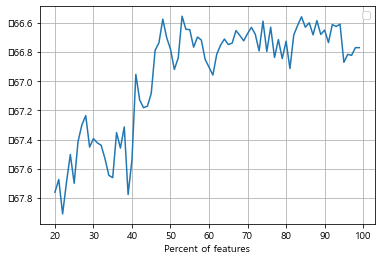

In [104]:
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")

model =  LGBMRegressor(random_state=1000)

cv_scores = []
for percentile in tqdm(range(20,100)):
    X_new = SelectPercentile(percentile = percentile).fit_transform(features__,df_y_train)
    cv_score = cross_val_score(model, X_new, df_y_train, scoring='neg_mean_squared_error', cv=5).mean()
    cv_scores.append((percentile, cv_score))

best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(model.__class__.__name__, best_score)

plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.legend(loc=0)
plt.grid()

In [105]:
fs = SelectPercentile(percentile=67).fit(features__, df_y_train)
features__ = fs.transform(features__)
features_t__ = fs.transform(features_t__)

print(features__.shape)
print(features_t__.shape)

(21587, 1028)
(14380, 1028)


In [106]:
pd.DataFrame(features__).to_csv("features__2rd_munnew.csv")
pd.DataFrame(features_t__).to_csv("features_t__2rd_munnew.csv")